### Data Processing

More about the data :

https://pravarmahajan.github.io/fashion/

https://juliaml.github.io/MLDatasets.jl/latest/datasets/FashionMNIST/#Contents-1

In [1]:
using MLDatasets, Plots, Images, TestImages

train_x, train_y = FashionMNIST.traindata()
test_x,  test_y  = FashionMNIST.testdata()

# Flatten the matrix input data into a vector
X_train = []   # Flattened 784 column vectors
Y_train = []   # One-hot encoding label vectors 
for i = 1:60000
    push!(X_train, reshape(train_x[:,:,i], 784))
    y = zeros(10)
    y[train_y[i] + 1] = 1.0
    push!(Y_train,y)
end

train_data = [x for x in zip(X_train, Y_train)];

# Flatten the matrix input data into a vector
X_valid = []   # Flattened 784 column vectors
Y_valid = []   # One-hot encoding label vectors 
for i = 1:10000
    push!(X_valid, reshape(test_x[:,:,i], 784))
    y = zeros(10)
    y[test_y[i] + 1] = 1.0
    push!(Y_valid,y)
end
test_data = [x for x in zip(X_valid, Y_valid)];

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal",      "Shirt",   "Sneaker",  "Bag",   "Ankle boot"]

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1273


10-element Array{String,1}:
 "T-shirt/top"
 "Trouser"    
 "Pullover"   
 "Dress"      
 "Coat"       
 "Sandal"     
 "Shirt"      
 "Sneaker"    
 "Bag"        
 "Ankle boot" 

### Functions:

In [2]:
function sigmoid(z)
    """ The sigmoid is an activation function that scales the output to this interval [0,1]."""
    return 1/(1+ exp(-z))
end

function dsigmoid(z)
    """ Sigmoid derivative """
    return sigmoid(z) * (1-sigmoid(z))
end


function forward_pass(W, b, x)
    """ This function is used for prediction
        Z = W'X + B
        A = Sigmoid(Z)
        The last entry of A is a vector of probabilities"""
    Z = [[0.0]]
    A = [x[1]]
    for i = 2:size(W)[1]
        push!(Z, W[i]*A[i-1] + b[i])
        push!(A, sigmoid.(Z[i]))
    end
    return Z, A
end


function quadratic_cost(prediction,real_label)
    """ This is the cost calculation for a single training entry."""
    return (0.5) * sum((real_label[i] - prediction[i])^2 for i = 1:length(prediction))
end
    

function total_quadratic_cost(labeled_data,W,b)
    """ This is the average cost across every training entry """
    cost = 0
    for i = 1:length(labeled_data)
        Z, A = forward_pass(W, b,labeled_data[i])
        aL = A[length(A)]
        cost += quadratic_cost(aL,labeled_data[i][2])
    end
    return cost/length(labeled_data)
end

function output_error(W,b,x,A,Z)
    """Equation for the error in the output layer.
        aLj - yj: is the error of neuron j and the 
        derivative of cost in respect to the activaction on neuron j and layer L.
        dsigmoid(zLj): derivative of sigmoid given pre-activation on neuron and 
        layer j,L - measures hor fast the activation function sigmoid is chaging at zLj."""
    return (A[end] - x[2]).*dsigmoid.(Z[end])
end

function back_prop(W, b, x) 
    """ Given the prediction (feed foward), and the output error, the derivative of cost function in respect 
    to bias and weights is found. This is needed to update the weights and bias."""
    Z, A = forward_pass(W, b, x)
    L = length(weights)
    deltas = Dict()
    deltas[L] = (A[end] - x[2]).*dsigmoid.(Z[end]) #hadamard_product 
    for i = L-1:-1:2
        deltas[i] = (W[i+1]'*deltas[i+1]).*dsigmoid.(Z[i])
    end
    return A, deltas
end

function stochastic_gradient_descent(W, b, data_set, batch_size, epochs, n, save_cost = true)
    """ Gradient descent applied to a random batch of training samples.
        This function updates the weights and bias"""
    
    W_new = copy(W)
    b_new = copy(b)
    L = length(W)
    
    if save_cost == true
        cost_points = [(0,total_quadratic_cost(data_set,W,b))]

        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, deltas = back_prop(W_new, b_new, x) 
                for i = L:-1:2
                    W_new[i] -= (n/batch_size)*deltas[i]*A[i-1]'
                    b_new[i] -= (n/batch_size)*deltas[i]
                end 
            end
            push!(cost_points, (j, total_quadratic_cost(data_set,W_new,b_new)))
        end
        return W_new, b_new , cost_points
        
    else
        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, deltas = back_prop(W_new, b_new, x) 
                for i = L:-1:2
                    W_new[i] -= (n/batch_size)*deltas[i]*A[i-1]'
                    b_new[i] -= (n/batch_size)*deltas[i]
                end 
            end
        end

        return W_new, b_new
    end
end


function random_predict(W, b, x)
    i = rand(1:length(x))
    Z, A = forward_pass(W, b, x[i])
    println("Predicted class:",class_names[argmax(A[end])])
    println("Actual class:", class_names[argmax(x[i][2])])
    return colorview(Gray, train_x[:,:,i]')
end

function predict(W, b, x,i)
    Z, A = forward_pass(W, b, x[i])
    return argmax(A[end])- 1 
end

function evaluation(W,b,x,train = true)
    """ Calculate Accuracy and Error for training(true)and test set (false). """
    if train == true
        accuracy = 0
        for i = 1:length(train_data)
            accuracy += sum( predict(W_new,b_new,train_data,i) == train_y[i] )
        end
        println("-----------------------------------------")
        println("Training Accuracy   |"," Training Error")
        println("     ",
            round.(accuracy/length(train_data); digits =3),
            "          |",
            "     ",
            round.(1 - accuracy/length(train_data);digits=3))
        println("-----------------------------------------")
    else
        accuracy = 0
        for i = 1:length(test_data)
            accuracy += sum( predict(W_new,b_new,test_data,i) == test_y[i] )
        end
        println("-----------------------------------------")
        println("Validation Accuracy |"," Validation Error")
        println("     ",
            round.(accuracy/length(test_data); digits =3),
            "          |",
            "     ",
            round.(1 - accuracy/length(test_data);digits=3))
        println("-----------------------------------------")
    end
end
    


evaluation (generic function with 2 methods)

### Training:

In [11]:
#weights = [[0.0],randn(60,784),randn(32,60),randn(10,32),randn(10,10)]
#weights = [[0.0],randn(200,784),randn(100,200),randn(60,100),randn(32,60),randn(10,32)]
weights = [[0.0],randn(60,784),randn(40,60),randn(10,40)] 
bias    = [[0.0], randn(60),randn(40),randn(10)]
W_new, b_new, cost =stochastic_gradient_descent(weights, bias,train_data, 10000, 100,700)
println("Done Training!")

Done Training!


### Visualization of cost function:

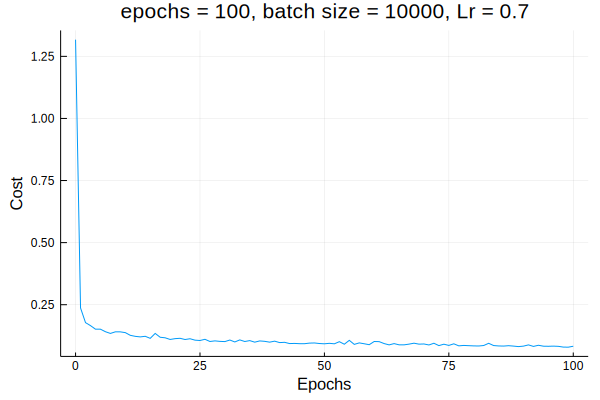

In [8]:
plot(cost, 
     xaxis = "Epochs", 
    yaxis = "Cost",
    title = "epochs = 100, batch size = 10000, Lr = 0.7",
    legend = false)

### Model Evaluation:

In [9]:
evaluation(W_new,b_new,train_data,false)
evaluation(W_new,b_new,train_data)

-----------------------------------------
Validation Accuracy | Validation Error
     0.851          |     0.149
-----------------------------------------
-----------------------------------------
Training Accuracy   | Training Error
     0.889          |     0.111
-----------------------------------------


Predicted class:Shirt
Actual class:Bag


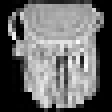

In [10]:
random_predict(W_new,b_new,train_data)